### SimCLR on CIFAR10 (with vs without augmentations)

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Load cifar10 and keep a small subset for speed
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

subset = 12000
x_train_small = x_train[:subset]
y_train_small = y_train[:subset]
input_shape = x_train_small.shape[1:]
num_classes = 10

In [29]:
# Augmentation builders
strong_aug = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.GaussianNoise(0.05),
])

def identity_aug(x):
    return x

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 256
temperature = 0.1
epochs = 6

def make_simclr_ds(images, aug_fn):
    ds = tf.data.Dataset.from_tensor_slices(images)
    ds = ds.shuffle(10000)
    ds = ds.map(lambda x: (aug_fn(x, training=True), aug_fn(x, training=True)), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

ds_aug = make_simclr_ds(x_train_small, strong_aug)
ds_plain = make_simclr_ds(x_train_small, lambda x, training=True: identity_aug(x))

In [23]:
def build_encoder():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, 3, padding='same', strides=2, activation='relu'),
        tf.keras.layers.Conv2D(128, 3, padding='same', strides=2, activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
])

def build_projector():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64),
])

In [24]:
def nt_xent(z1, z2, temperature=0.1):
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)
    z = tf.concat([z1, z2], axis=0)  # (2B, d)
    sim = tf.matmul(z, z, transpose_b=True) / temperature
    batch_size = tf.shape(z1)[0] * 2
    diag_mask = tf.eye(batch_size)
    sim = sim - 1e9 * diag_mask  # remove self-similarity
    # Positive mask: pairs (i, i+B) and (i+B, i)
    b = tf.shape(z1)[0]
    pos_mask_top = tf.concat([tf.zeros((b, b)), tf.eye(b)], axis=1)
    pos_mask_bottom = tf.concat([tf.eye(b), tf.zeros((b, b))], axis=1)
    pos_mask = tf.concat([pos_mask_top, pos_mask_bottom], axis=0)
    exp_sim = tf.exp(sim)
    log_prob = tf.math.log(tf.reduce_sum(exp_sim * pos_mask, axis=1) / tf.reduce_sum(exp_sim, axis=1))
    loss = -tf.reduce_mean(log_prob)
    return loss

In [25]:
@tf.function
def train_step(encoder, projector, optimizer, x1, x2):
    with tf.GradientTape() as tape:
        h1 = encoder(x1, training=True)
        h2 = encoder(x2, training=True)
        z1 = projector(h1, training=True)
        z2 = projector(h2, training=True)
        loss = nt_xent(z1, z2, temperature)
    grads = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + projector.trainable_variables))
    return loss

In [26]:
def train_simclr(ds):
    encoder = build_encoder()
    projector = build_projector()
    # build variables once to avoid creation inside tf.function
    dummy = tf.zeros((1,) + input_shape)
    h_dummy = encoder(dummy, training=False)
    _ = projector(h_dummy, training=False)
    optimizer = tf.keras.optimizers.Adam(1e-3)
    optimizer.build(encoder.trainable_variables + projector.trainable_variables)

    @tf.function
    def train_step(x1, x2):
        with tf.GradientTape() as tape:
            h1 = encoder(x1, training=True)
            h2 = encoder(x2, training=True)
            z1 = projector(h1, training=True)
            z2 = projector(h2, training=True)
            loss = nt_xent(z1, z2, temperature)
        grads = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
        optimizer.apply_gradients(zip(grads, encoder.trainable_variables + projector.trainable_variables))
        return loss

    history = []
    for epoch in range(epochs):
        losses = []
        for x1, x2 in ds:
            loss = train_step(x1, x2)
            losses.append(loss.numpy())
        history.append(np.mean(losses))
        print(f"Epoch {epoch+1}/{epochs} - loss: {history[-1]:.4f}")
    return encoder, projector, history

encoder_aug, projector_aug, loss_aug = train_simclr(ds_aug)
encoder_plain, projector_plain, loss_plain = train_simclr(ds_plain)

I0000 00:00:1767669726.375784   14063 cuda_dnn.cc:529] Loaded cuDNN version 91701
2026-01-06 08:52:10.607340: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/6 - loss: 2.8415


2026-01-06 08:52:12.817609: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/6 - loss: 1.2538
Epoch 3/6 - loss: 0.8349


2026-01-06 08:52:17.230441: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/6 - loss: 0.6292
Epoch 5/6 - loss: 0.5514
Epoch 6/6 - loss: 0.4972
Epoch 1/6 - loss: 2.2822


2026-01-06 08:52:22.860149: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/6 - loss: 0.6077
Epoch 3/6 - loss: 0.3224
Epoch 4/6 - loss: 0.2217
Epoch 5/6 - loss: 0.1771
Epoch 6/6 - loss: 0.1601


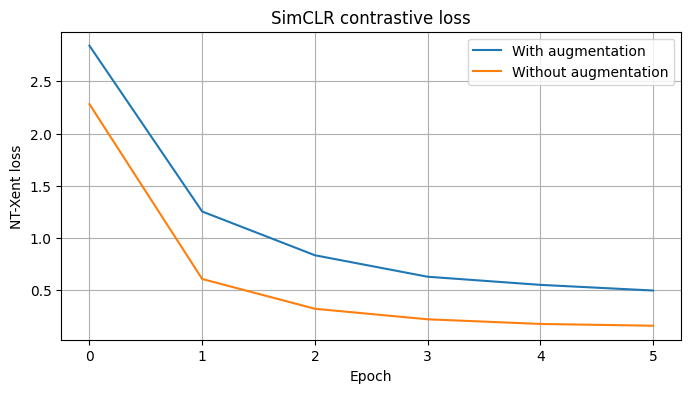

In [27]:
plt.figure(figsize=(8,4))
plt.plot(loss_aug, label='With augmentation')
plt.plot(loss_plain, label='Without augmentation')
plt.xlabel('Epoch')
plt.ylabel('NT-Xent loss')
plt.title('SimCLR contrastive loss')
plt.legend()
plt.grid(True)
plt.show()